In [5]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from tqdm import tqdm

In [19]:
transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), torchvision.transforms.Grayscale(num_output_channels=3), transforms.ToTensor()])
trainset = datasets.FashionMNIST('data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
testset = datasets.FashionMNIST('data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Move data loaders to the GPU
trainloader = [(data.to(device), target.to(device)) for data, target in trainloader]
testloader = [(data.to(device), target.to(device)) for data, target in testloader]

cuda:0


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [7]:
trainloader.dataset.data.shape

torch.Size([60000, 28, 28])

In [8]:
testloader.dataset.data.shape

torch.Size([10000, 28, 28])

In [9]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

Feature batch shape: torch.Size([100, 3, 224, 224])
Labels batch shape: torch.Size([100])


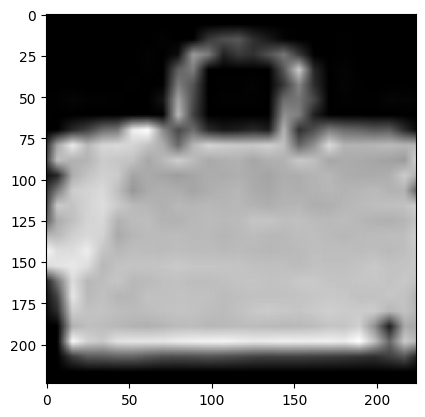

Label: 8


In [10]:
#nex iter gets next 100 images
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[99][0].squeeze()
label = train_labels[99]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [11]:
from torchvision import models
all_models = models.list_models()
m1 = torchvision.models.get_model("mobilenet_v3_small", num_classes=10, num_channels=1)
# Move your model to the GPU if available
m1.to(device)

In [12]:
optimizer = torch.optim.Adam(m1.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [13]:
batch1, label1=next(iter(trainloader))


In [14]:
predicted = m1(batch1)

In [15]:
# Freeze all layers
for param in m1.parameters():
    param.requires_grad = False

# Unfreeze last layer
for param in m1.classifier.parameters():
    param.requires_grad = True

In [17]:
#epoch loss and accuracy
tr_loss, tr_acc = [], []
te_loss, te_acc = [], []
max_epochs = 10

for t in range(max_epochs):
    m1.train()
    batch_loss, batch_accuracy = [], []
    for X,y in tqdm(trainloader):
        pred = m1(X)
        loss = loss_fn(pred, y)
        batch_accuracy.append(float(torch.argmax(predicted, dim=1).eq(y).sum().item()/len(y)))
        batch_loss.append(float(loss.item()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    batches = len(batch_loss)
    tr_loss.append(sum(batch_loss)/batches)
    tr_acc.append(sum(batch_accuracy)/batches)

    m1.eval()
    with torch.no_grad():
        batch_loss, batch_accuracy = [], []

        for X,y in testloader:
            pred = m1(X)
            loss = loss_fn(pred, y)
            batch_accuracy.append(float(torch.argmax(predicted, dim=1).eq(y).sum().item()/len(y)))
            batch_loss.append(float(loss.item())) 
        batches = len(batch_loss)
        te_loss.append(sum(batch_loss)/batches)
        te_acc.append(sum(batch_accuracy)/batches)
        
    
    print(f"Epoch {t+1}: Train_accuracy: {(100*tr_acc[-1]):>0.2f}%, Train_loss: {tr_loss[-1]:>8f}, Test_accuracy: {(100*te_acc[-1]):>0.2f}%, Test_loss: {te_loss[-1]:>8f}")

  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor